In [1]:
!pip install -q tensorflow-recommenders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.9 MB/s eta 0:00:00


In [2]:
import tensorflow_recommenders as tfrs
print(f"TensorFlow Recommenders version: {tfrs.__version__}")

TensorFlow Recommenders version: v0.7.3


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the data (you've already done this part)
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")

In [5]:
# Combine datasets for more training data
all_train = pd.concat([train, train_extra], ignore_index=True)
print(all_train.shape)
all_train[:10]

(3994318, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
5,5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
7,7,Puma,Canvas,Small,1.0,Yes,Yes,Backpack,Blue,21.488864,27.15815
8,8,Under Armour,Polyester,Medium,8.0,Yes,No,Tote,Gray,10.207780,25.98652
9,9,Under Armour,Nylon,Medium,2.0,Yes,Yes,Messenger,Pink,15.895100,38.48741


In [6]:
all_train.isnull().sum()

id                           0
Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [7]:
display(all_train.drop(columns=["Price"]).describe())

,id,Compartments,Weight Capacity (kg)
count,3.994318e+06,3.994318e+06,3.992510e+06
mean,2.182137e+06,5.434740e+00,1.801042e+01
std,1.178058e+06,2.893043e+00,6.973969e+00
min,0.000000e+00,1.000000e+00,5.000000e+00
25%,1.198579e+06,3.000000e+00,1.206896e+01
50%,2.197158e+06,5.000000e+00,1.805436e+01
75%,3.195738e+06,8.000000e+00,2.398751e+01
max,4.194317e+06,1.000000e+01,3.000000e+01


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

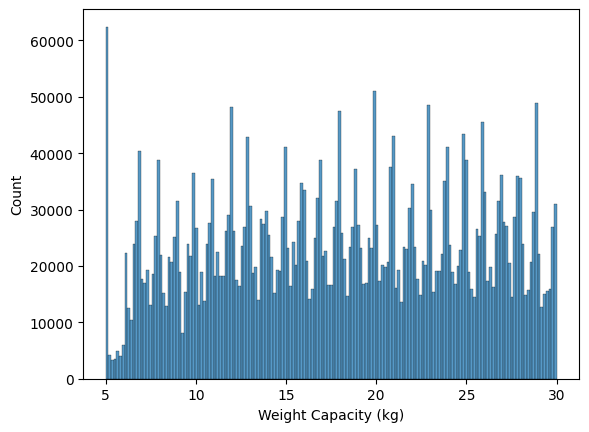

In [8]:
sns.histplot(all_train["Weight Capacity (kg)"])

,count,mean,std,min,25%,50%,75%,max
Price,3994318.0,81.362175,38.938684,15.0,47.47002,80.98495,114.855,150.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

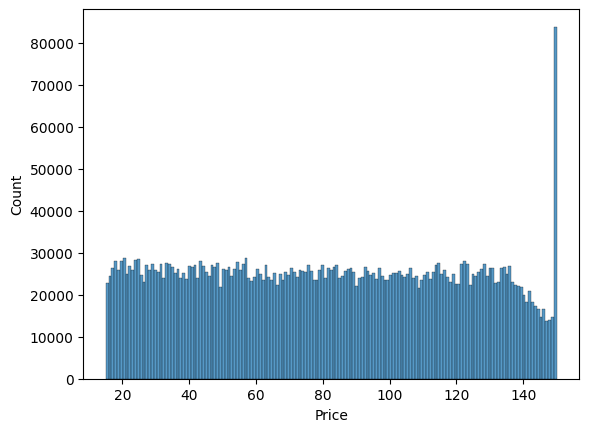

In [9]:
display(all_train.Price.describe().to_frame().T)

sns.histplot(all_train.Price)

In [10]:
# First, handle missing values
if all_train['Weight Capacity (kg)'].isnull().any():
    # Impute with the median
    median_weight = all_train['Weight Capacity (kg)'].median()
    all_train['Weight Capacity (kg)'].fillna(median_weight, inplace=True)

# Round to nearest integer to capture the spikes
all_train['Weight Capacity Int'] = all_train['Weight Capacity (kg)'].round().astype(int)

<ipython-input-10-5f42238228f6>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_train['Weight Capacity (kg)'].fillna(median_weight, inplace=True)


In [11]:
categorical_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
numerical_features = ['Compartments', 'Weight Capacity Int']
target = 'Price'



In [12]:
X = all_train.drop(['id', target, 'Weight Capacity (kg)'], axis=1)
y = all_train[target]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipelines for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [13]:

# Get the input dimensions for the model
input_dim = X_train_preprocessed.shape[1]

In [14]:
def build_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    
    return model


def build_dcn_model(input_dim, num_cross_layers=2, projection_dim=None):
    """
    Build a Deep & Cross Network model using TFRS implementation
    
    Args:
        input_dim: Dimension of input features
        num_cross_layers: Number of cross layers to use
        projection_dim: If not None, uses low-rank approximation for cross layers
    """
    # Input layer
    inputs = keras.Input(shape=(input_dim,))
    
    # Cross Network
    x_cross = inputs
    for _ in range(num_cross_layers):
        # Using the TFRS implementation of Cross layer
        x_cross = tfrs.layers.dcn.Cross(
            projection_dim=projection_dim,
            diag_scale=0.1,  # Small value to improve stability
            kernel_regularizer=keras.regularizers.l2(1e-4)
        )(x_cross)
    
    # Deep Net
    x_deep = keras.layers.Dense(128, activation='relu')(inputs)
    x_deep = keras.layers.BatchNormalization()(x_deep)
    x_deep = keras.layers.Dropout(0.3)(x_deep)
    
    x_deep = keras.layers.Dense(64, activation='relu')(x_deep)
    x_deep = keras.layers.BatchNormalization()(x_deep)
    x_deep = keras.layers.Dropout(0.2)(x_deep)
    
    x_deep = keras.layers.Dense(32, activation='relu')(x_deep)
    x_deep = keras.layers.BatchNormalization()(x_deep)
    x_deep = keras.layers.Dropout(0.2)(x_deep)
    
    x_deep = keras.layers.Dense(16, activation='relu')(x_deep)
    
    # Combine the two networks
    combined = keras.layers.Concatenate()([x_cross, x_deep])
    
    combined = keras.layers.Dense(32, activation='relu')(combined)
    
    # Output layer
    outputs = keras.layers.Dense(1)(combined)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

# Create the model (standard)
# model = build_model(input_dim)
# Create model, DCN
model = build_dcn_model(input_dim)

# Define callbacks for training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

In [15]:
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=5,
    batch_size=1024,
    # steps_per_epoch=1000, # comment for full data
    # validation_steps=1000,
    validation_data=(X_val_preprocessed, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 2279.1643 - mean_absolute_error: 39.2371 - val_loss: 1515.3527 - val_mean_absolute_error: 33.6520 - learning_rate: 0.0010
Epoch 2/5
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1517.0428 - mean_absolute_error: 33.6785 - val_loss: 1515.6718 - val_mean_absolute_error: 33.6485 - learning_rate: 0.0010
Epoch 3/5
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1515.3169 - mean_absolute_error: 33.6518 - val_loss: 1513.5276 - val_mean_absolute_error: 33.6370 - learning_rate: 0.0010
Epoch 4/5
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1515.3745 - mean_absolute_error: 33.6559 - val_loss: 1513.5089 - val_mean_absolute_error: 33.6340 - learning_rate: 0.0010
Epoch 5/5
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1515.1588 - mean_absolute_error: 33.6544 - val_loss: 1513.2590 - val_mean_absolute_error: 33.6321 - learning_rate: 0.0010


In [16]:
# Function to make predictions on test data
def predict_price(model, preprocessor, new_data):
    # We need to apply the same preprocessing to test data
    if 'Weight Capacity (kg)' in new_data.columns:
        # Handle missing values
        if new_data['Weight Capacity (kg)'].isnull().any():
            median_weight = new_data['Weight Capacity (kg)'].median()
            new_data['Weight Capacity (kg)'].fillna(median_weight, inplace=True)
        
        # Round to nearest integer
        new_data['Weight Capacity Int'] = new_data['Weight Capacity (kg)'].round().astype(int)
        
        # Drop the columns we don't need
        new_data = new_data.drop(['Weight Capacity (kg)'], axis=1)
    
    # Transform the data and predict
    new_data_preprocessed = preprocessor.transform(new_data)
    predictions = model.predict(new_data_preprocessed)
    return predictions


In [17]:
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
print("Test shape", test.shape )
test[:5]

Test shape (200000, 10)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [18]:
preds = predict_price(model, preprocessor, test)

<ipython-input-16-98d6baecae21>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data['Weight Capacity (kg)'].fillna(median_weight, inplace=True)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


In [19]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = preds
sub.to_csv(f"submission.csv",index=False)
sub.head()

,id,Price
0,300000,81.522156
1,300001,83.120911
2,300002,82.007141
3,300003,80.757401
4,300004,77.623260
